In [1]:
%matplotlib inline

In [2]:
tensorflow version: 1.12.0-rc0
scikit-learn version: 0.17
keras version: 2.2.4
tensorboard version: 1.10

SyntaxError: invalid syntax (<ipython-input-2-9040ce9384a7>, line 1)

# Transfer Learning
In this assignment, we will use the weights of a network pre-trained in a particular problem as starting point to train our CNN to a different problem. As training a network from scratch is time-consuming and demands a lot of data, this is a frequent strategy, specially if both datasets (the one used for pre-training and the target) shares similar structures/elements/concepts. 

This is specially true when working with images. Most filters learned in initial convolutional layers will detect low-level elements, such as borders, corners and color blobs, which are common to most problems in the image domain. 

In this notebook, we will load the SqueezeNet architecture trained in the ImageNet dataset and fine-tune it to CIFAR-10.

## Imports

In [3]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, Flatten, Dense
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam, Adamax, Nadam, SGD, Adadelta
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from sklearn.cross_validation import StratifiedShuffleSplit

# import preprocess input used in imagenet
from keras.applications.imagenet_utils import preprocess_input

#Utility to plot
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

C:\Users\Pichau\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Pichau\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## SqueezeNet definition
These methods define our architecture and load the weights obtained using ImageNet data.

In [4]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class are **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**.

Train data. X:  (40000, 32, 32, 3) , Y:  (40000, 1)
Validation data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)
Test data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)


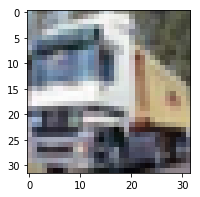

Result:  truck


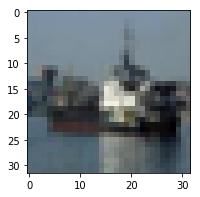

In [5]:
#Load data
(train_X, train_Y), (test_X, test_Y) = cifar10.load_data()

# separate data between train and validation
valid_X, valid_Y = train_X[40000:], train_Y[40000:]
train_X, train_Y = train_X[:40000], train_Y[:40000]

print("Train data. X: ", train_X.shape, ", Y: ", train_Y.shape)
print("Validation data. X: ", valid_X.shape, ", Y: ", valid_Y.shape)
print("Test data. X: ", test_X.shape, ", Y: ", test_Y.shape)

# The names of the classes in the cifar 10 dataset
CLASS_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

# Show an example of an image and the label
plotImage(train_X[1])
print("Result: ", CLASS_NAMES[np.asscalar(train_Y[1])])

# Prepare the data
# preprocess the image by subtracting the mean RGB pixel intensity from the ImageNet dataset
# and show an example from the validation set
#train_X = preprocess_input(train_X)
#valid_X = preprocess_input(valid_X)
#train_X = preprocess_input(train_X)
plotImage(valid_X[1])

In [6]:
# Transform targets to keras compatible format with cifar-10
train_Y = np_utils.to_categorical(train_Y, 10)
valid_Y = np_utils.to_categorical(valid_Y, 10)
test_Y = np_utils.to_categorical(test_Y, 10)
print(train_Y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


-----------------
## SqueezeNet with frozen layers
Our initial attempt will be to remove SqueezeNet's top layers --- responsible for the classification into ImageNet classes --- and train a new set of layers to our CIFAR-10 classes. We will also freeze the layers before `drop9`. Our architecture will be like this:

<img src="frozenSqueezeNet.png" width=70% height=70%>

In [ ]:
squeezeNetModel = SqueezeNet((32,32,3))

#freeze layers
for layer in squeezeNetModel.layers:
    layer.trainable = False
    
# remove layers
squeezeNetModel.layers.pop()
squeezeNetModel.layers.pop()
squeezeNetModel.layers.pop()
squeezeNetModel.layers.pop()

#Add new classification layers
x = squeezeNetModel.output
x = Convolution2D(10, (1, 1), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax', name='loss')(x)

#new Model
model = Model((32,32,3), x, name='cifar10-frozen-layers')
print([layer.name for layer in model.layers])
model.summary()

Now, we compile our model and train it:

In [ ]:
# Compile model and train it.

# compile model
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
    
# train model
model.fit(train_X, train_Y, epochs=epochs, shuffle=True, verbose=1)

Finally, let's evaluate on our test set:

In [ ]:
# Evaluate on validation:
score = model.evaluate(valid_X, valid_Y, verbose=1)

print('Validation loss:', score[0])
print('Validation accuracy (NORMALIZED):', score[1])

-----------------
-----------------

# Training last 2 Fire Modules + classification layers
As we could see, the frozen network performed very poorly. By freezing most layers, we do not allow SqueezeNet to adapt its weights to features present in CIFAR-10.

Let's try to unfreeze the last two fire modules and train once more. The architecture will be:
<img src="partFrozenSqueezeNet.png" width=70% height=70%>

In [6]:
squeezeNetModel = SqueezeNet((32,32,3))

print([layer.name for layer in squeezeNetModel.layers])

#freeze the mentioned layers
for layer in squeezeNetModel.layers[:48]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in squeezeNetModel.layers:
    print(layer.name, layer.trainable)

# remove layers
squeezeNetModel.layers.pop()
squeezeNetModel.layers.pop()
squeezeNetModel.layers.pop()
squeezeNetModel.layers.pop()

#Add new classification layers
x = squeezeNetModel.output
x = Convolution2D(10, (1, 1), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax', name='loss')(x)

#new Model
model = Model((32,32,3), x, name='cifar10-train-last-two-fire-layers')
print([layer.name for layer in model.layers])
model.summary()

['input_1', 'conv1', 'relu_conv1', 'pool1', 'fire2/squeeze1x1', 'fire2/relu_squeeze1x1', 'fire2/expand1x1', 'fire2/expand3x3', 'fire2/relu_expand1x1', 'fire2/relu_expand3x3', 'fire2/concat', 'fire3/squeeze1x1', 'fire3/relu_squeeze1x1', 'fire3/expand1x1', 'fire3/expand3x3', 'fire3/relu_expand1x1', 'fire3/relu_expand3x3', 'fire3/concat', 'pool3', 'fire4/squeeze1x1', 'fire4/relu_squeeze1x1', 'fire4/expand1x1', 'fire4/expand3x3', 'fire4/relu_expand1x1', 'fire4/relu_expand3x3', 'fire4/concat', 'fire5/squeeze1x1', 'fire5/relu_squeeze1x1', 'fire5/expand1x1', 'fire5/expand3x3', 'fire5/relu_expand1x1', 'fire5/relu_expand3x3', 'fire5/concat', 'pool5', 'fire6/squeeze1x1', 'fire6/relu_squeeze1x1', 'fire6/expand1x1', 'fire6/expand3x3', 'fire6/relu_expand1x1', 'fire6/relu_expand3x3', 'fire6/concat', 'fire7/squeeze1x1', 'fire7/relu_squeeze1x1', 'fire7/expand1x1', 'fire7/expand3x3', 'fire7/relu_expand1x1', 'fire7/relu_expand3x3', 'fire7/concat', 'fire8/squeeze1x1', 'fire8/relu_squeeze1x1', 'fire8/expa

Now, we compile our model and train it:

In [ ]:
#Compile model and train it

# compile model
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
    
# train model
model.fit(train_X, train_Y, epochs=epochs, shuffle=True, verbose=1)

Finally, let's evaluate on our test set:

In [ ]:
# Evaluate on validation.
score = model.evaluate(test_X, test_Y, verbose=1)

print('Validation loss:', score[0])
print('Validation accuracy (NORMALIZED):', score[1])

-----------
-----------
-----------
# Tensorboard

Tensorboard is a visualization tool for Tensorflow. Among other things, it allows us to monitor the progress of our training, plot metrics per epochs, visualize the architecture's schematics. 

Just like for Early Stopping, we will use the [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to log the information about our training. An example of usage, would be:

As your training progresses, Keras will log the metrics (e.g., loss, accuracy) to `<<LOG_DIR>>` (**make sure `<<LOG_DIR>>` is a valid directory)**. On your terminal, you will need to run Tensorboard, assign a port and access it via browser (just like jupyter).

#### ----> MAKE SURE YOU USE A DIFFERENT PORT FOR JUPYTER AND TENSORBOARD <----

### Docker
For those using docker, open a new terminal and create a new container (using the same image) running Tensorboard:

For example:

After starting Tensorboard, access it via browser on `http://localhost:<<port_container>>`.

### Anaconda
$ tensorboard --logdir=<<LOG_DIR>> --port=<<port>>

After starting Tensorboard, access it via browser on `http://localhost:<<port>>`.

-----------
-----------
-----------

# Fine-tuning all layers

What if we fine-tune all layers of SqueezeNet?
<img src="unfrozenSqueezeNet.png" width=70% height=70%>

In [13]:
squeezeNetModel = SqueezeNet((32,32,3))

for layer in squeezeNetModel.layers:
    layer.trainable = True       #by default they are all trainable, but just for clarification

# Remove layers
squeezeNetModel.layers.pop()
squeezeNetModel.layers.pop()
squeezeNetModel.layers.pop()
squeezeNetModel.layers.pop()

# Add new classification layers
x = squeezeNetModel.layers[-1].output
x = Convolution2D(10, (1, 1), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax', name='loss')(x)

# Create a new model
model = Model(squeezeNetModel.inputs, x, name='cifar10-fine-tuning')

Now, we compile our model and train it:

In [14]:
from time import time

#Compile model
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#Tensorboard callback
tbCallBack = TensorBoard(log_dir="./tensorboard".format(time()), write_graph=True)

#Fine-tuning the model
model.fit(train_X, train_Y, epochs=10, shuffle=True, verbose=1, callbacks=[tbCallBack])

Epoch 1/10
40000/40000 [==============================] - 57s 1ms/step - loss: 2.1719 - acc: 0.2309
Epoch 2/10
40000/40000 [==============================] - 50s 1ms/step - loss: 1.6185 - acc: 0.4650
Epoch 3/10
40000/40000 [==============================] - 52s 1ms/step - loss: 1.2915 - acc: 0.5826
Epoch 4/10
40000/40000 [==============================] - 54s 1ms/step - loss: 1.1242 - acc: 0.6369
Epoch 5/10
40000/40000 [==============================] - 53s 1ms/step - loss: 1.0043 - acc: 0.6727
Epoch 6/10
40000/40000 [==============================] - 52s 1ms/step - loss: 0.9281 - acc: 0.6994
Epoch 7/10
40000/40000 [==============================] - 54s 1ms/step - loss: 0.8578 - acc: 0.7203
Epoch 8/10
40000/40000 [==============================] - 56s 1ms/step - loss: 0.7983 - acc: 0.7388
Epoch 9/10
40000/40000 [==============================] - 52s 1ms/step - loss: 0.7501 - acc: 0.7557
Epoch 10/10
40000/40000 [==============================] - 51s 1ms/step - loss: 0.7077 - acc: 0.7691

Finally, let's evaluate on our validation set:

In [15]:
# Evaluate on validation.
score = model.evaluate(valid_X, valid_Y, verbose=1)

print('Validation loss:', score[0])
print('Validation accuracy (NORMALIZED):', score[1])

10000/10000 [==============================] - 29s 3ms/step
Validation loss: 0.8720002248764038
Validation accuracy (NORMALIZED): 0.7206


In [16]:
# Evaluate your best model on test
score = model.evaluate(test_X, test_Y, verbose=1)

print('Validation loss:', score[0])
print('Validation accuracy (NORMALIZED):', score[1])

10000/10000 [==============================] - 6s 590us/step
Validation loss: 0.9025474694252014
Validation accuracy (NORMALIZED): 0.715


## Saving the model
Now that we are working on more complex tasks and our trainings are starting to take more time it is usually a good idea to save the trained model from time to time. [Keras has a lot of ways of saving and loading the model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model), but in this exercise we will use the simplest of them all: `model.save()`. It saves the architecture, the weights, the choice of loss function/optimizer/metrics and even the current state of the training, so you can resume your training later.

In [11]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

## Loading a model
Once we have our model trained, we can load it using:

In [12]:
from keras.models import load_model

del model  # Will delete model, only to check if load_model is working

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

# evaluate test set again... should give us the same result
score = model.evaluate(test_X, test_Y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])

10000/10000 [==============================] - 3s 326us/step
Test loss: 0.8790382322311401
Test accuracy (NORMALIZED): 0.7167
